# Trialing generative processes for chemical microscopy (part 1)

Is it possible to use a generative process to model microscope images like this (and is it worth the effort?)

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns
from numpyro import deterministic, plate, sample
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam
from PIL import Image

sns.set_theme('notebook', 'ticks', font='Arial')

plt.rcParams['figure.dpi'] = 200

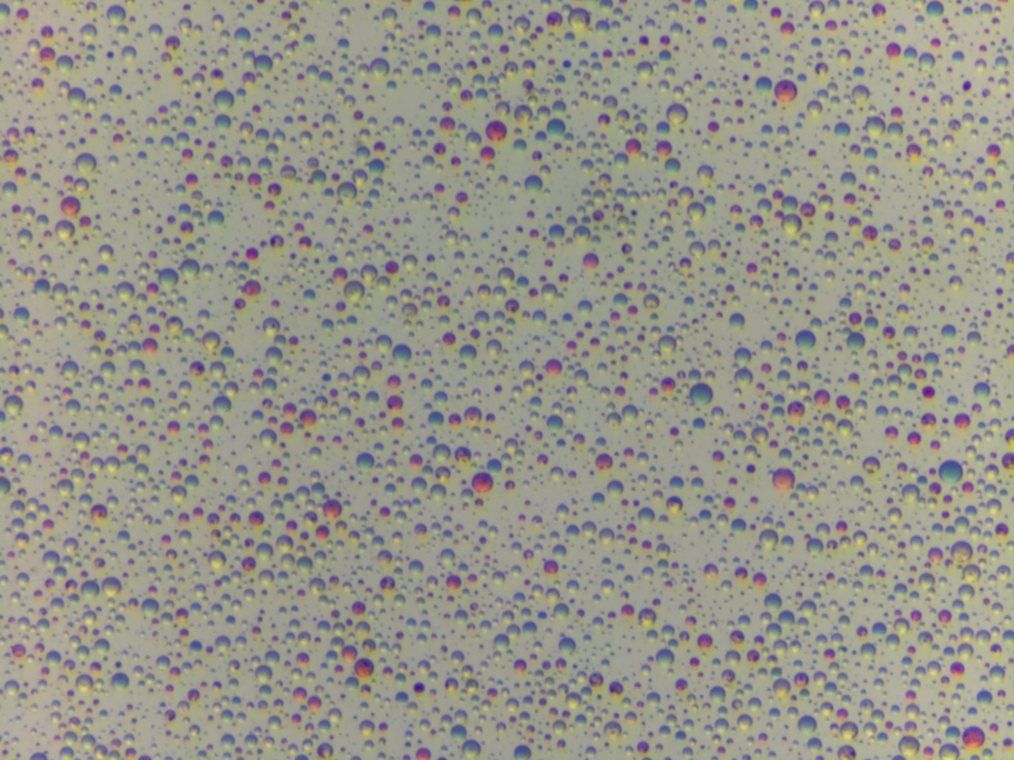

In [2]:
img = Image.open('data/example.jpg')
img = img.resize((img.width // 2, img.height // 2))
img

Try a couple of different colour spaces in case something interesting stands out.

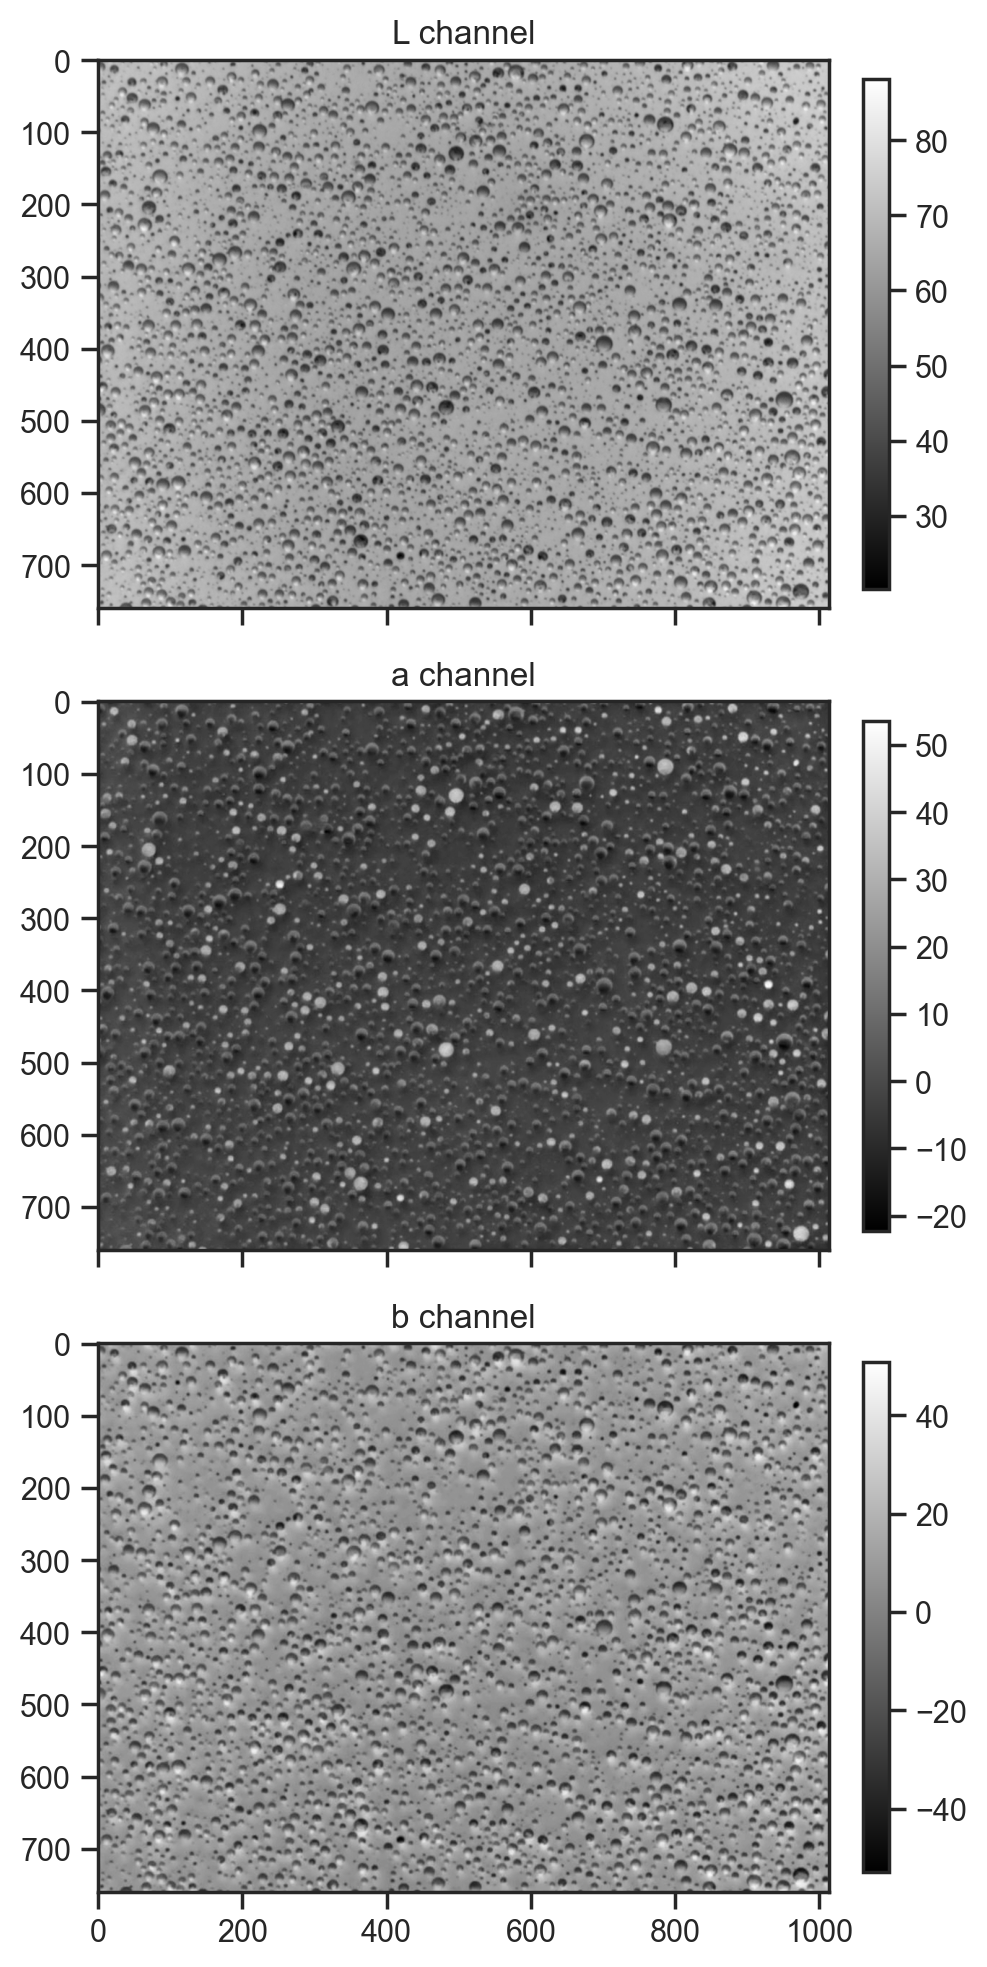

In [3]:
from skimage import color

img_array = np.array(img)
lab_img = color.rgb2lab(img_array)

fig, axes = plt.subplots(3, 1, figsize=(5, 10), sharex=True)

for i, (ax, title) in enumerate(zip(axes, ['L channel', 'a channel', 'b channel'])):
    im = ax.imshow(lab_img[:,:,i], cmap='gray')
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)

plt.tight_layout()

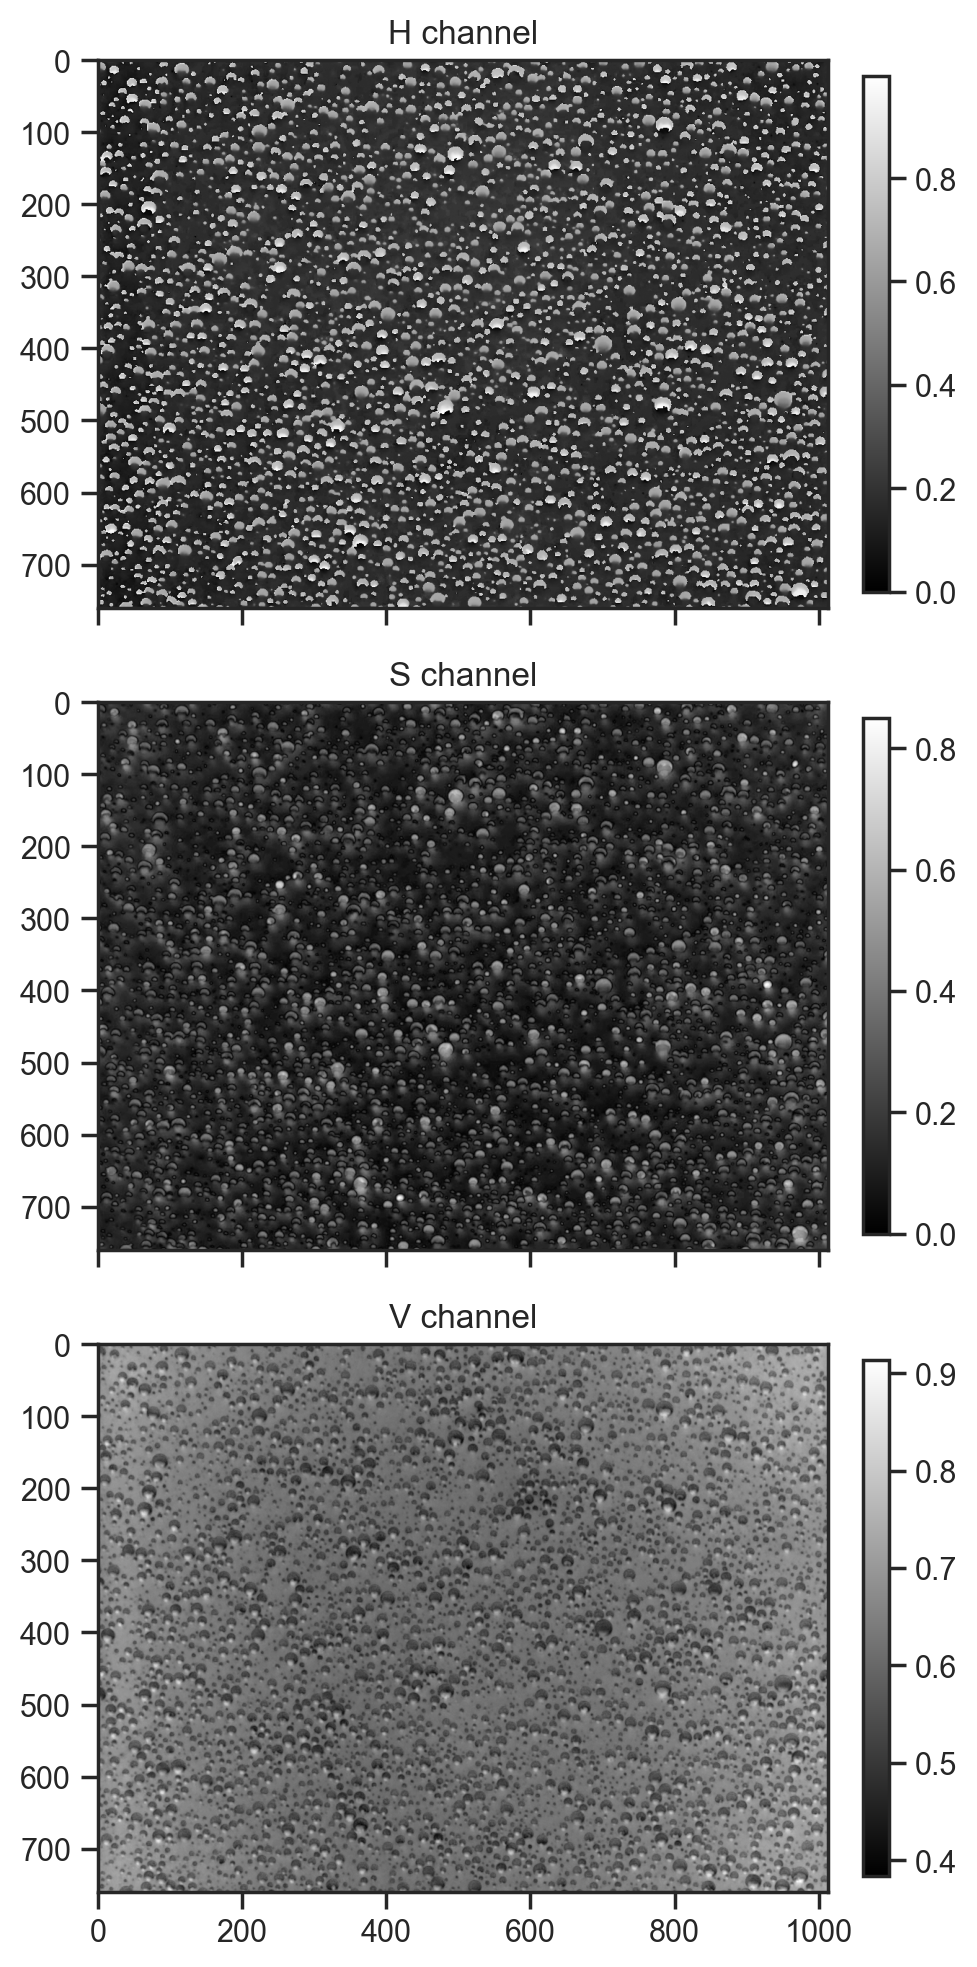

In [4]:
hsv_img = color.rgb2hsv(img_array)

fig, axes = plt.subplots(3, 1, figsize=(5, 10), sharex=True)

for i, (ax, title) in enumerate(zip(axes, ['H channel', 'S channel', 'V channel'])):
    im = ax.imshow(hsv_img[:,:,i], cmap='gray')
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)

plt.tight_layout()

First approach, fixed number of droplets; model centres and radii

sample: 100%|██████████| 1100/1100 [00:09<00:00, 112.09it/s, 15 steps of size 3.08e-01. acc. prob=0.84]


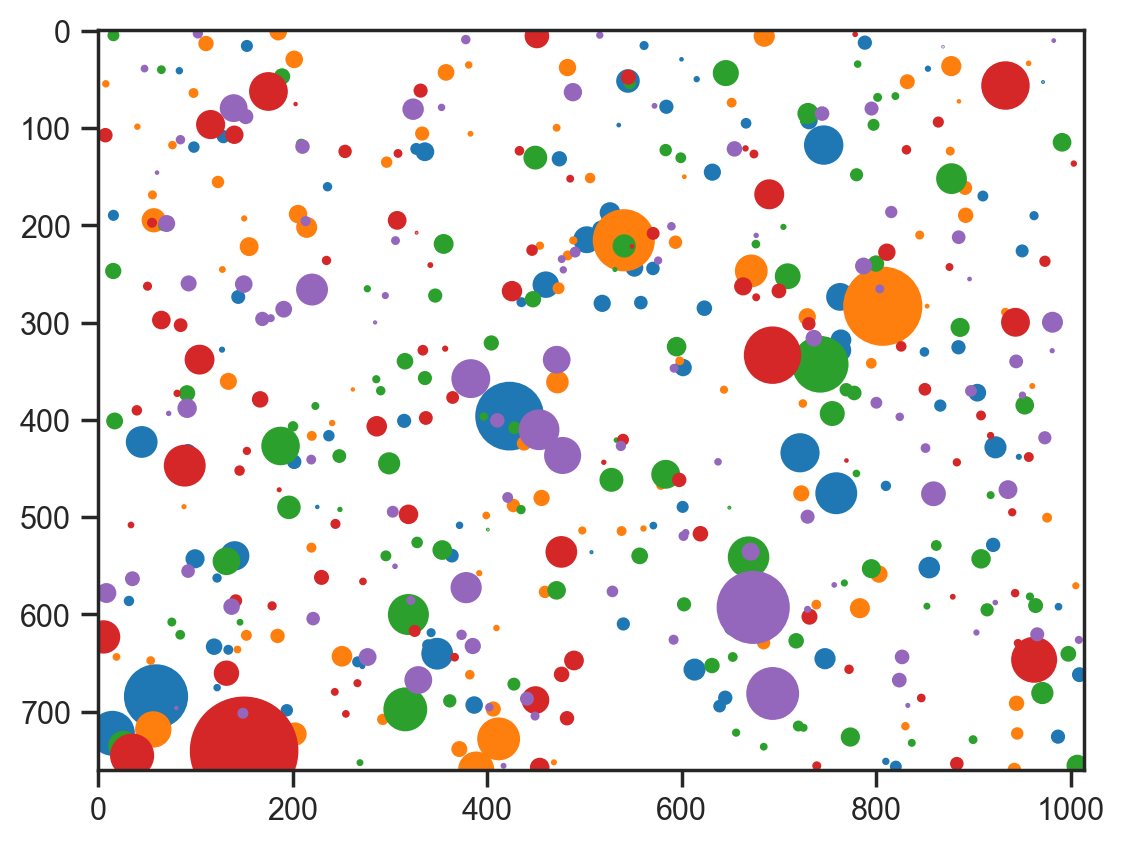

In [5]:
def model1(w, h, n_droplets):
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(1.5, 0.75))


mcmc = MCMC(NUTS(model1), num_warmup=1000, num_samples=100)
mcmc.run(jax.random.PRNGKey(0), w=img.width, h=img.height, n_droplets=100)
samples = mcmc.get_samples()

fig, ax = plt.subplots()
ax.imshow(np.ones_like(np.array(img)) * 255, cmap="gray")
for sample_no in range(5):
    for i in range(100):
        circle = plt.Circle(
            (samples["x"][sample_no][i], samples["y"][sample_no][i]),
            samples["r"][sample_no][i],
            color=plt.cm.tab10(sample_no),
        )

        ax.add_artist(circle)

sample: 100%|██████████| 1100/1100 [00:14<00:00, 74.39it/s, 15 steps of size 2.52e-01. acc. prob=0.86] 


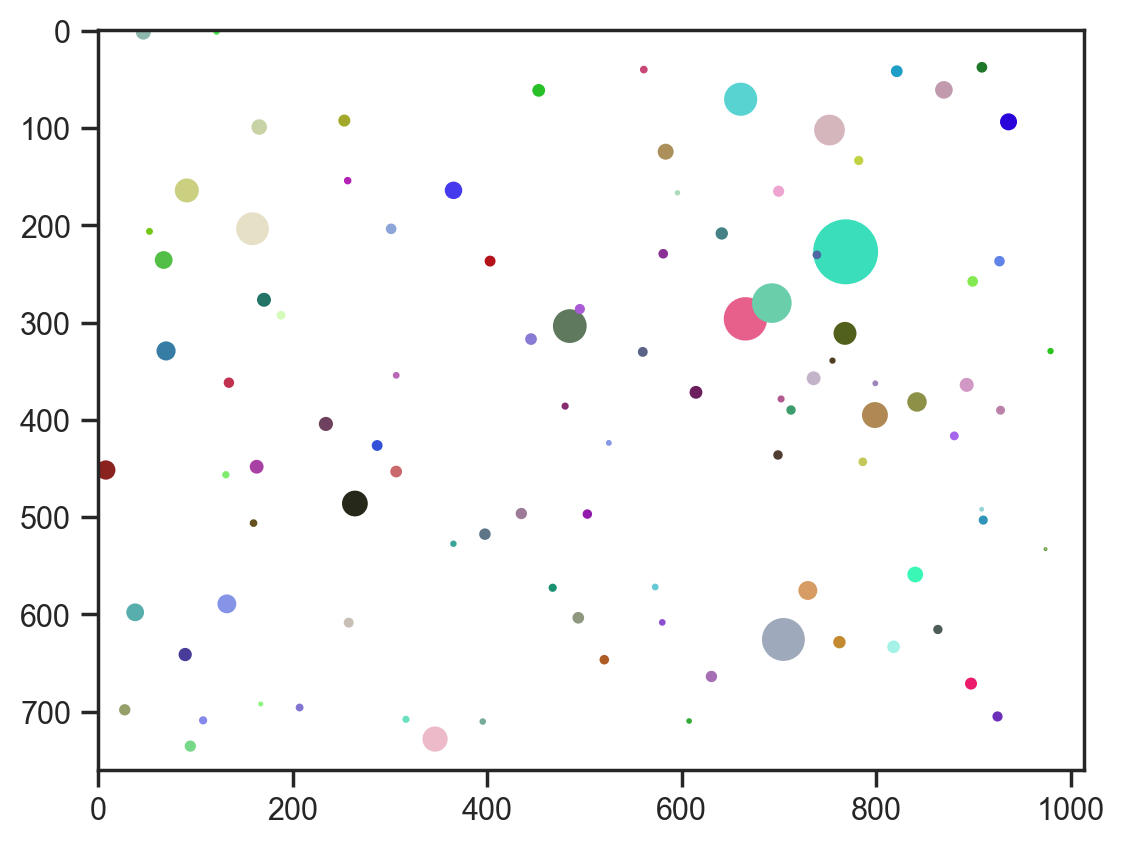

In [6]:
def model2(w, h, n_droplets):
    # Sample droplet locations and sizes
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(1.5, 0.75))
        
        # Sample HSV values for each droplet
        h_val = sample("h", dist.Uniform(0, 1))
        s_val = sample("s", dist.Beta(2, 2))
        v_val = sample("v", dist.Beta(5, 2))  # Biased towards brighter values

mcmc = MCMC(NUTS(model2), num_warmup=1000, num_samples=100)
mcmc.run(jax.random.PRNGKey(0), w=img.width, h=img.height, n_droplets=100)
samples = mcmc.get_samples()
samples = {k: np.array(v) for k, v in samples.items()}

# Visualize with HSV colors
fig, ax = plt.subplots()
ax.imshow(np.ones_like(np.array(img)) * 255, cmap="gray")
for i in range(100):
    circle = plt.Circle(
        (samples["x"][0][i], samples["y"][0][i]),
        samples["r"][0][i],
        color=color.hsv2rgb(
            np.array(
                [
                    samples["h"][0][i],
                    samples["s"][0][i],
                    samples["v"][0][i],
                ]
            )
        ),
    )
    ax.add_artist(circle)

sample: 100%|██████████| 510/510 [00:06<00:00, 78.12it/s, 15 steps of size 3.10e-01. acc. prob=0.85] 


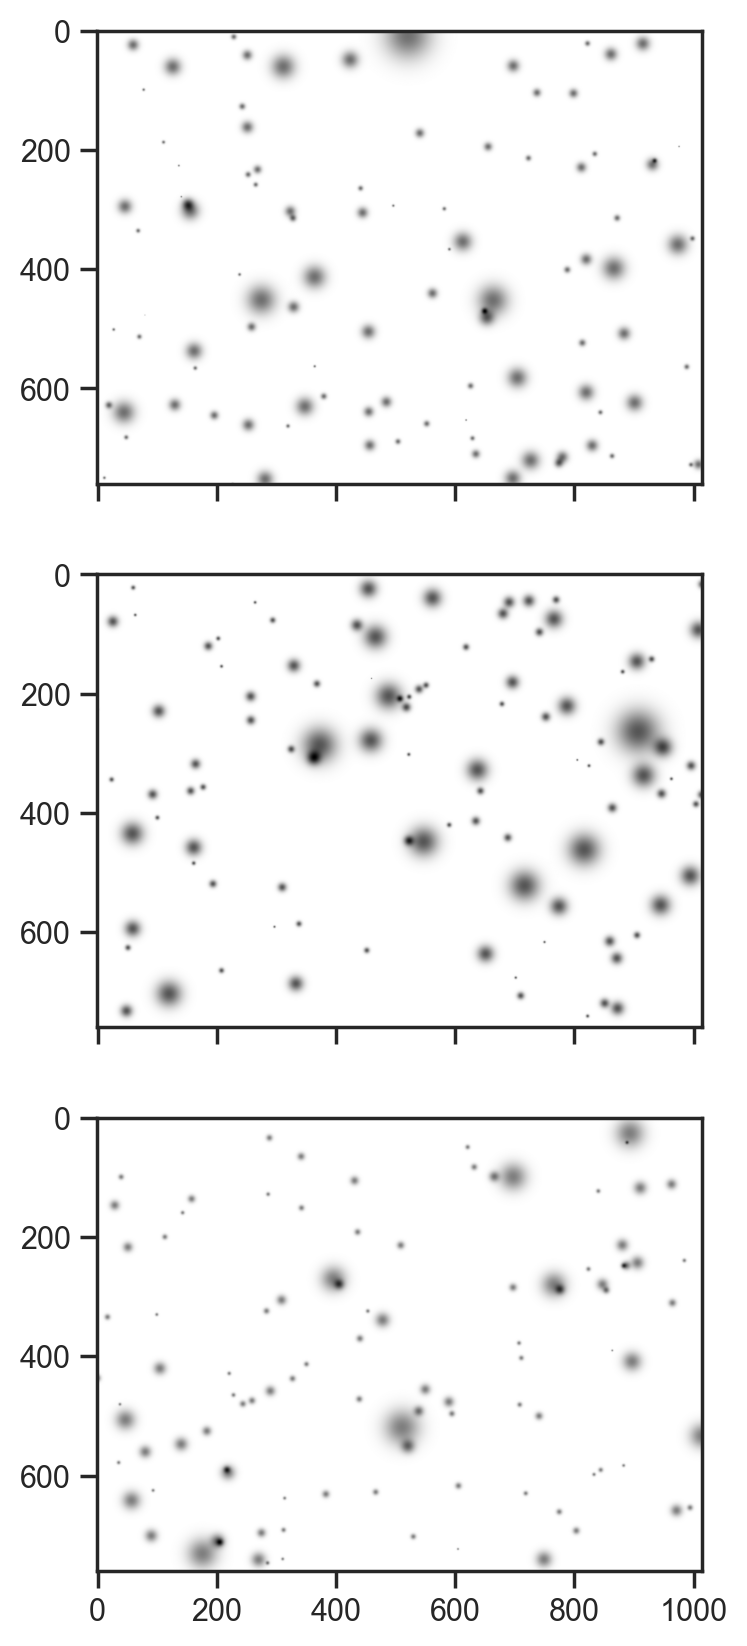

In [7]:
def model2(w, h, n_droplets):
    # Sample droplet locations and sizes
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(1.5, 0.75))
        
        with plate("pixels", w * h):
            x_dist = jnp.abs(x - jnp.arange(w)[:, None])
            y_dist = jnp.abs(y - jnp.arange(h)[:, None])
            distance = jnp.sqrt(x_dist ** 2 + y_dist[:, None] ** 2)
            val = deterministic('val', jnp.sum(jnp.exp(-distance ** 2 / (2 * r ** 2)), axis=-1))


mcmc = MCMC(NUTS(model2), num_warmup=500, num_samples=10)
mcmc.run(jax.random.PRNGKey(0), w=img.width, h=img.height, n_droplets=100)
samples = mcmc.get_samples()
samples = {k: np.array(v) for k, v in samples.items()}

# show the first 3 samples
fig, axes = plt.subplots(3, 1, figsize=(5, 10), sharex=True)
for i, ax in enumerate(axes):
    ax.imshow(1 - samples['val'][i], cmap='gray')

Not a bad generative process to start with. Now let's just fit the hue channel ...

In [50]:
def model3(w, h, n_droplets, channel, error_scale):
    # Sample droplet locations and sizes
    bg = sample("bg", dist.Uniform(0, 1))
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, 1))*w
        y = sample("y", dist.Uniform(0, 1))*h
        r = sample("r", dist.LogNormal(1.5, 0.75))
        amplitude = sample("amplitude", dist.Uniform(0, 1))
        
        x_dist = jnp.abs(x - jnp.arange(w)[:, None])
        y_dist = jnp.abs(y - jnp.arange(h)[:, None])
        distance = jnp.sqrt(x_dist ** 2 + y_dist[:, None] ** 2)
        val = deterministic('val', bg + jnp.sum(amplitude[None, None, :] * jnp.exp(-distance ** 2 / (2 * r ** 2)), axis=-1))
        diff = deterministic('diff', val - channel)
    sample('obs', dist.Normal(0, error_scale), obs=val - channel)


Fitting, instead of sampling

In [90]:
guide = AutoNormal(model3)
svi = SVI(model3, guide, Adam(0.01), Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), 20000, img.width, img.height, 500, hsv_img[:,:,0], 0.05)

100%|██████████| 20000/20000 [04:40<00:00, 71.43it/s, init loss: 19718028.0000, avg. loss [19001-20000]: 5279295.0000]


In [109]:
svi_result = svi.run(jax.random.PRNGKey(0), 50000, img.width, img.height, 500, hsv_img[:,:,0], 0.05, init_state=svi_result.state)

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [11:36<00:00, 71.82it/s, init loss: 5101927.5000, avg. loss [47501-50000]: 5046932.5000]


In [110]:
samples = guide.sample_posterior(jax.random.PRNGKey(0), svi_result.params, sample_shape=(5,))

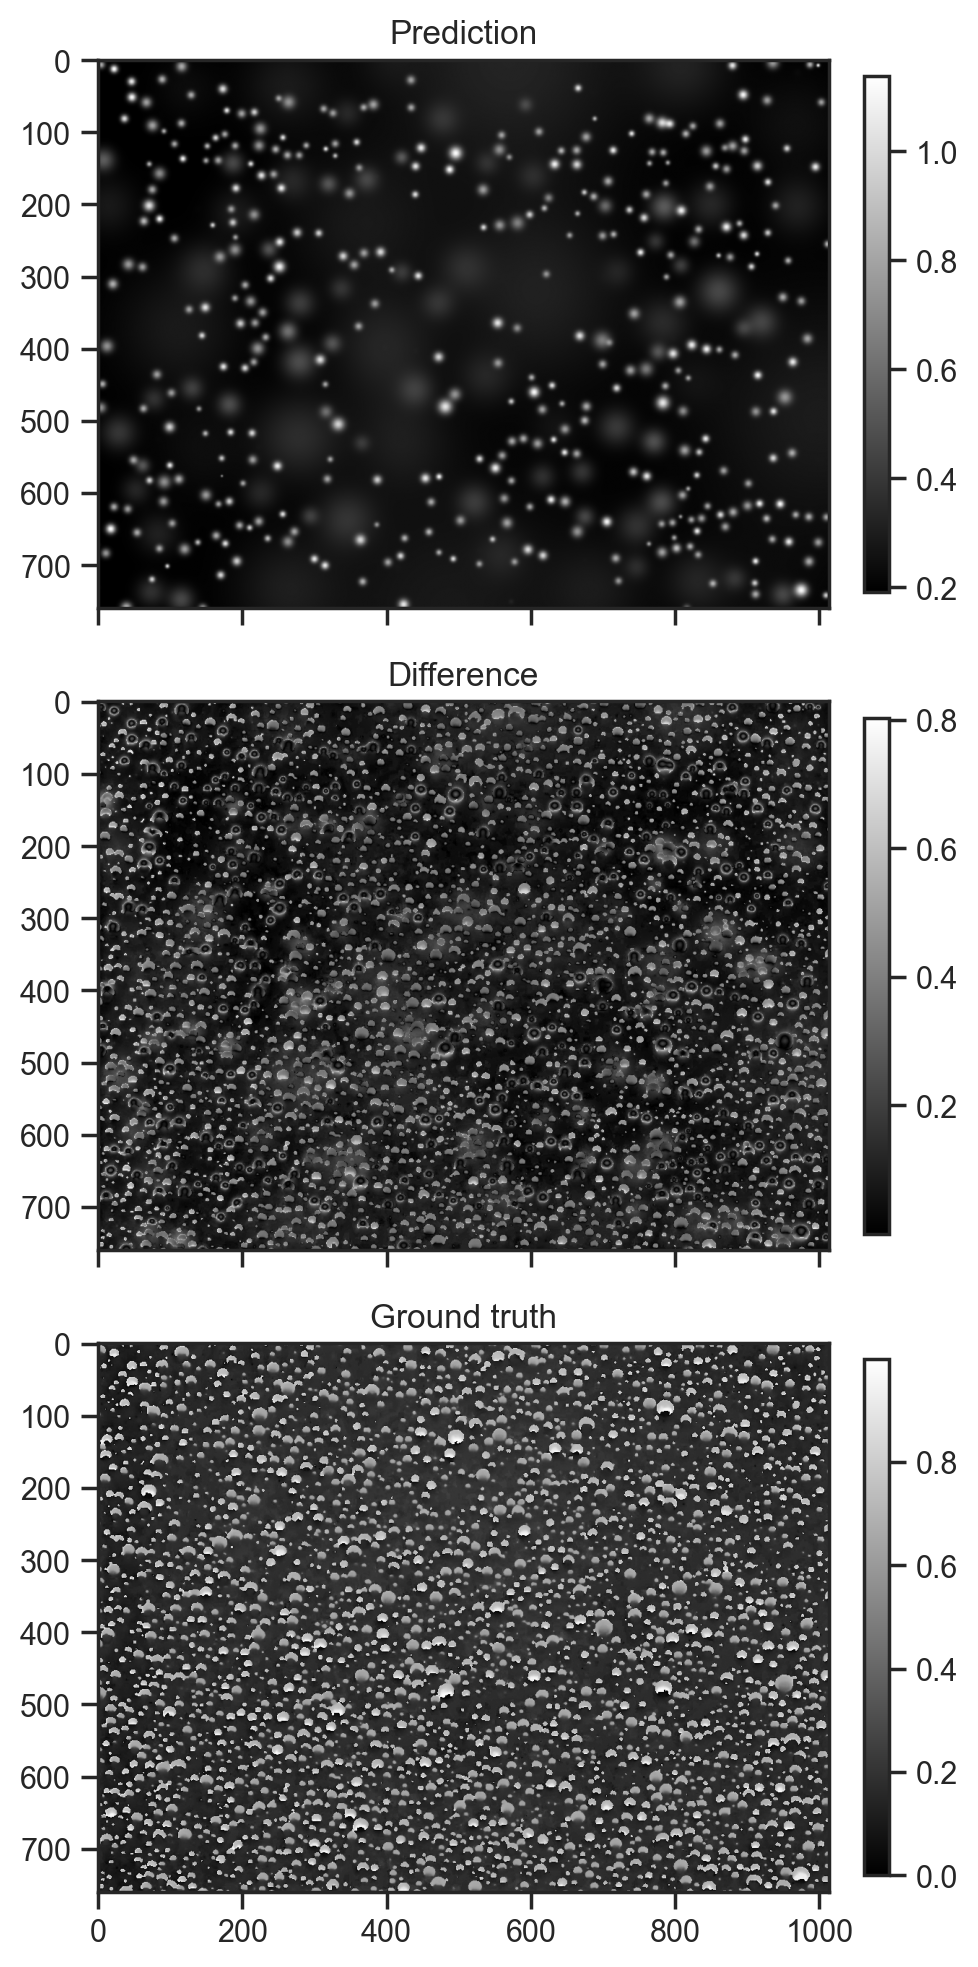

In [111]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10), sharex=True)
fig.colorbar(axes[0].imshow(samples['val'][0], cmap='gray'), ax=axes[0], fraction=0.03, pad=0.04)
axes[0].set_title('Prediction')
fig.colorbar(axes[1].imshow(jnp.abs(samples['diff'][0]), cmap='gray'), ax=axes[1], fraction=0.03, pad=0.04)
axes[1].set_title('Difference')
fig.colorbar(axes[-1].imshow(hsv_img[:,:,0], cmap='gray'), ax=axes[-1], fraction=0.03, pad=0.04)
axes[-1].set_title('Ground truth')
fig.tight_layout()

Not a bad start. Most of the brightests spots have been fitted. I am surprised thought that a lot of the amplitudes are almost zero. At the end of the day, optimisations where pieces have to move into the right place first are tricky and I have no reason to believe that this is a global optimum, despite having spent a while trying to tease out a better outcome.

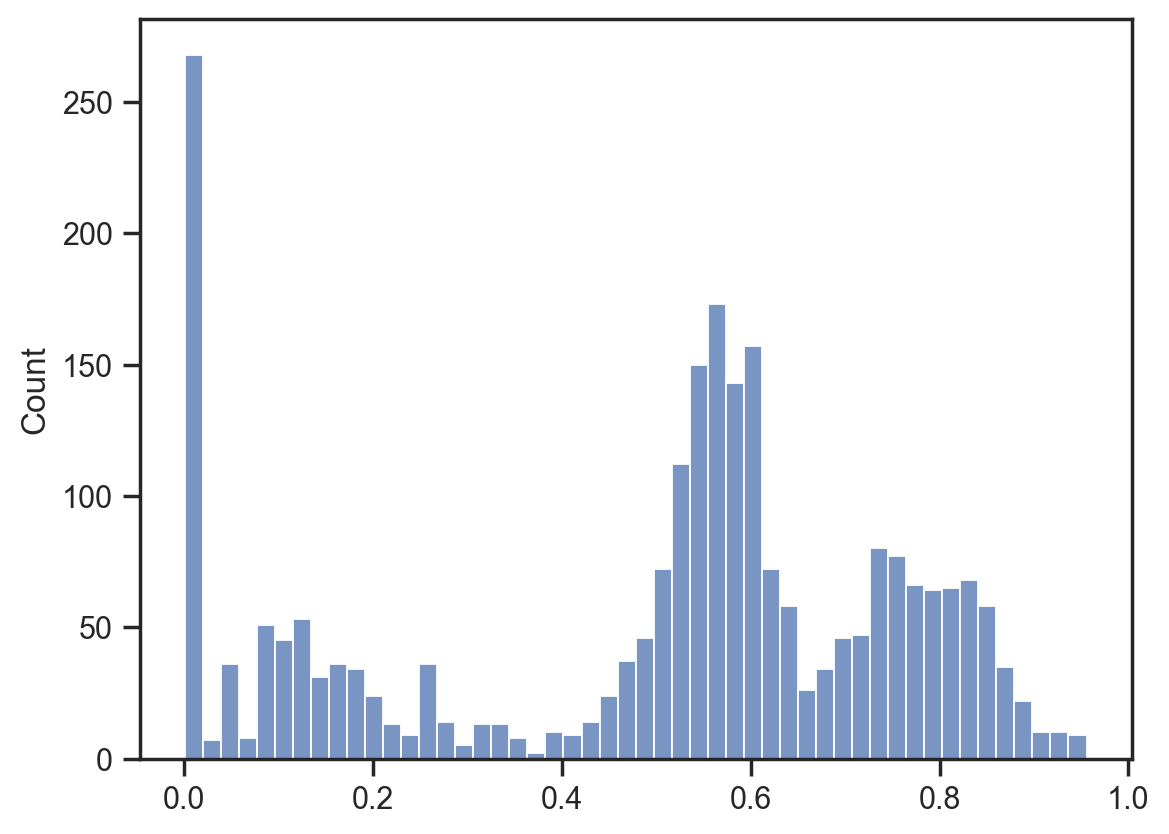

In [112]:
sns.histplot(samples['amplitude'].flatten(), bins=50);